# Invariant Information Clustering for Unsupervised Image Classification and Segmentation

https://arxiv.org/pdf/1807.06653v4.pdf  
https://arxiv.org/pdf/2210.04142.pdf  





## **1. Introduction**

Unsupervised clustering aims to group data points into classes entirely without labels  

trivially combining clustering and representation learning methods often leads to degenerate solution  

introduce invariant information clustering that addresses this issue in a more principled manner  

It involves a simple objective function, which is the mutual information between the functions's classfications for paired data samples  

IIC is intrinsically robust to two issues that affect other methods.  
**1. clustering degeneracy**  
 - tendency for a single cluster to dominate the predictions or for clusters to disappear  

**2. noisy data with unknown or distractor classes**


## **3. Method**  

The goal of IIC is to learn a representation $ɸ : X → Y$ that preserves what is in common between $x$ and $x'$ while discarding instance-specific details.

$\max_ɸ I(ɸ(x), ɸ(x'))$ ...(1)  

eq.(1) : it is to make representations of paired samples the same.  
it is not the same as merely minimising representation distance as done for example in methods based on k-means

$P = \frac{1}{n} ∑_{i=1}^n ɸ(x_i) ⋅ ɸ(x'_i)^T$ ,where $P_{cc'} = P(z=c, z'=c')$ ... (2)  
To generally consider symmetric problems, where for each $(x_i,x'_i)$ we also have $(x'_i,x_i)$, $P$ is symmetrized using $(P+P^T)/2$  

$I(z,z') = I(P) = ∑_{c=1}^C ∑_{c'=1}^C P_{cc'} ⋅ \log \frac{P_{cc'}}{P_c \cdot P_{c'}}$ ... (3)  

**Why mutual information?**  
1. due to the soft clustering, entropy alone could be maximised trivially by setting all prediction vectors to uniform distribution  
2. objective of IIC is to find what is common between two data points that share redundancy such as different images of the same object

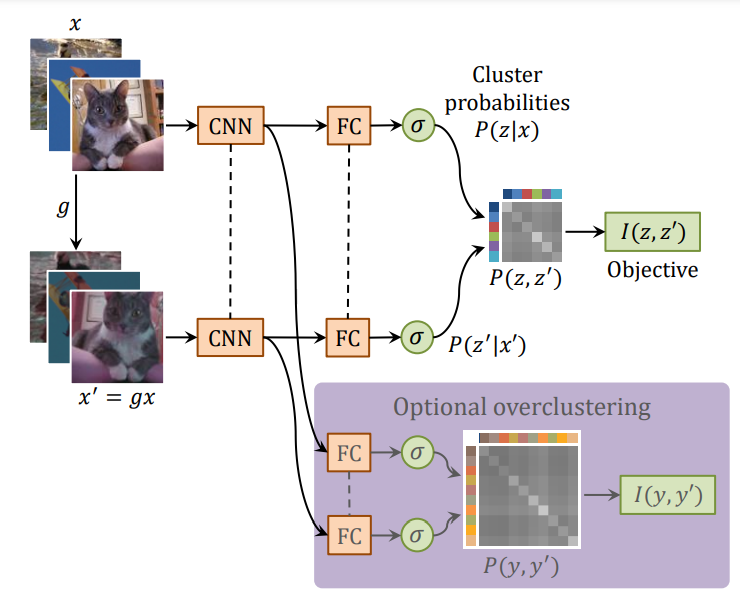

**Auxiliary overclustering**  

For certain datasets, training data comes in two types: one known to contain only relevant classes and the other known to contain irrelevant or distractor classes.  
It is desirable to train a clusterer specialised for the relevant classes.  

Add an auxiliary overclustering head to the network that is trained with the full dataset, whilst the main output head is trained with the subset containing only relevant classes  

This allows us to make use of the noisy unlabelled subset

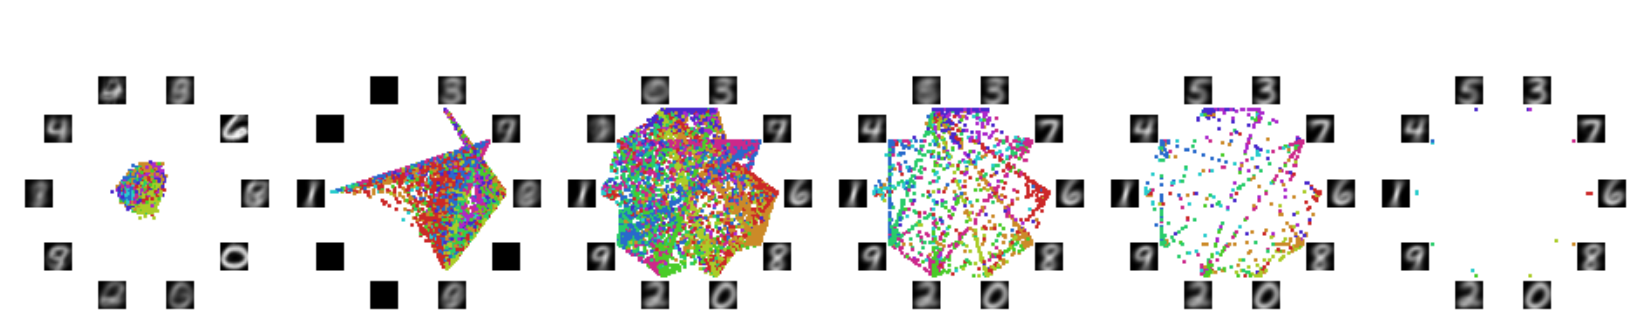

## **4. Experiments**

**Image clustering**

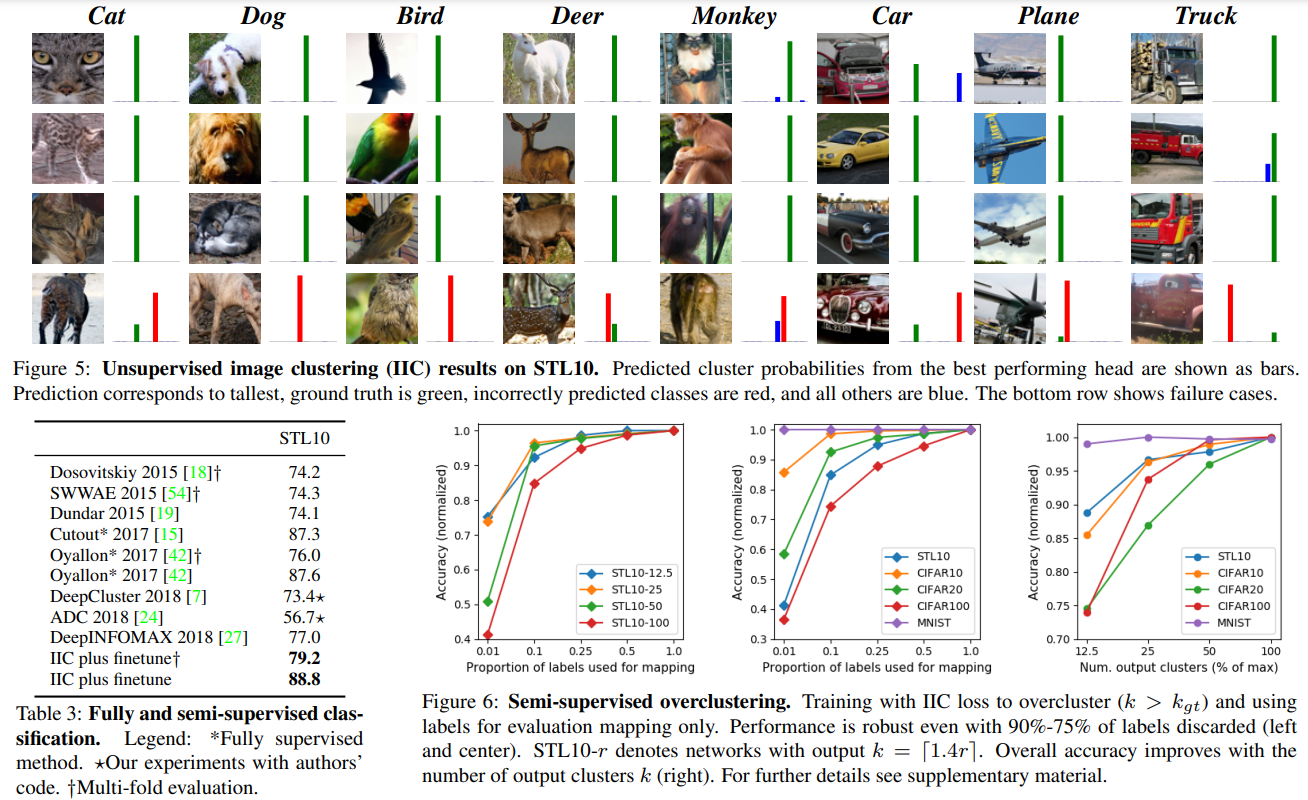

**Segmentation**

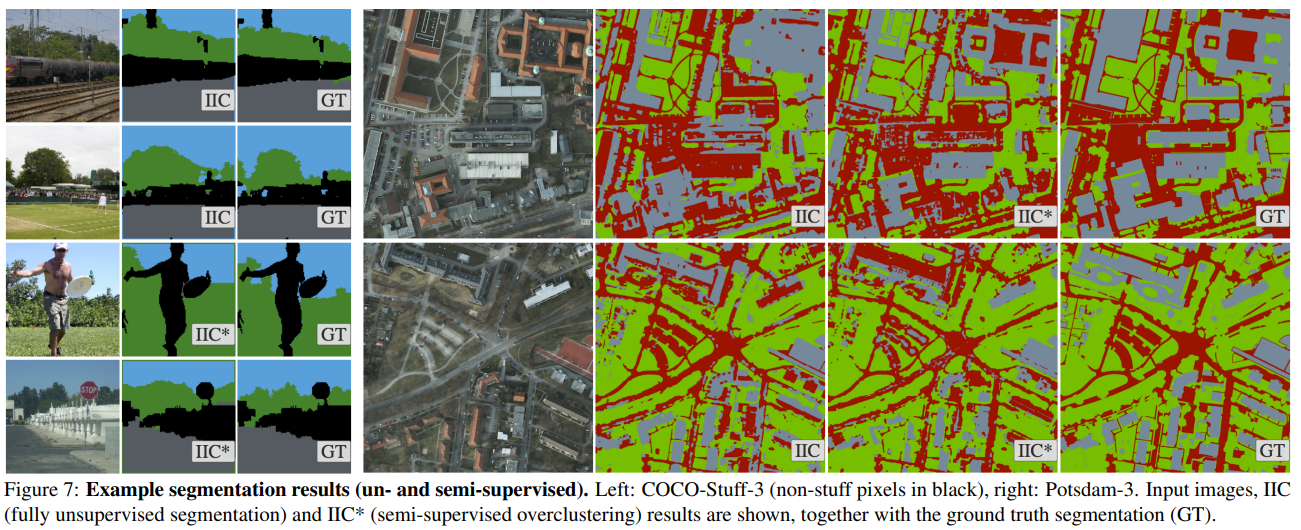

# **Implementation**

In [ ]:
# library

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets
from torchvision.utils import make_grid

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load data

class IIC_dataset(Dataset):
    def __init__(self, train, dataset='mnist'):
        super(IIC_dataset, self).__init__()
        c = 1 if dataset=='mnist' else 3
        self.std_map = T.Compose([T.ToTensor(),
                                  T.Resize((32,32)),
                                  T.Normalize([0.5]*c,[0.5]*c)])
        self.ran_map = T.Compose([T.ToTensor(),
                                  T.Resize((32,32)),
                                  T.RandomHorizontalFlip(),
                                  T.GaussianBlur(kernel_size=(5,5)),
                                  T.ColorJitter(brightness=(0.5, 0.9),
                                                contrast=(0.4, 0.8),
                                                saturation=(0.7, 0.9),
                                                hue=(-0.2, 0.2)),
                                  T.Normalize([0.5]*c,[0.5]*c),])
        self.dataset = datasets.MNIST('./mnist', train=train, download=True) \
                       if dataset=='mnist' else \
                       datasets.CIFAR10('./cifar', train=train, download=True)
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        origin = self.std_map(img)
        transf = self.ran_map(img)
        return origin, transf


In [ ]:
# load dataset

dataset = IIC_dataset(True, 'mnist')
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 81488566.79it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30028679.68it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22256557.51it/s]


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6129513.76it/s]


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


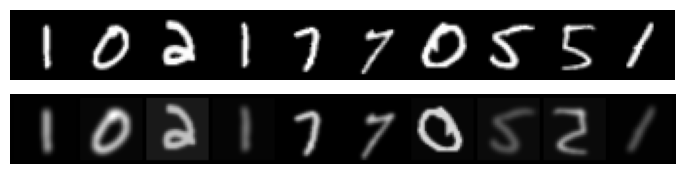

In [ ]:
x, x_ = next(iter(dataloader))
origin = make_grid(x[:10], nrow=10, normalize=True)
transf = make_grid(x_[:10], nrow=10, normalize=True)

fig, ax = plt.subplots(2,1, figsize=(10,2))
ax[0].imshow(np.transpose(origin, (1,2,0)))
ax[0].axis('off')
ax[1].imshow(np.transpose(transf, (1,2,0)))
ax[1].axis('off')
fig.show()

In [ ]:
# Base Block

class BB(nn.Module):
    def __init__(self, in_channel, out_channel, down):
        super(BB, self).__init__()
        self.cv1 = nn.Conv2d(in_channel, out_channel, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.cv2 = nn.Conv2d(out_channel, out_channel, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.re = nn.ReLU(inplace=True)
        self.down = down
        if self.down:
            self.ds = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, 1, 0, bias=False),
                nn.BatchNorm2d(out_channel))
    def forward(self, x):
        x0 = x.clone()
        x = self.re(self.bn1(self.cv1(x)))
        x = self.bn2(self.cv2(x))
        if self.down:
            x0 = self.ds(x0)
        return self.re(x + x0)

# Resnet

class ResNet(nn.Module):
    def __init__(self, channels, layers, img_chnl):
        super(ResNet, self).__init__()
        self.cv = nn.Conv2d(img_chnl, channels[0], 3, 1, 1, bias=False)
        self.layer1 = nn.Sequential(*[
            BB(channels[0], channels[0], False) for _ in range(layers[0])  ])
        self.down1 = nn.Sequential(
            BB(channels[0], channels[1], True),
            nn.MaxPool2d((2,2)) )

        self.layer2 = nn.Sequential(*[
            BB(channels[1], channels[1], False) for _ in range(layers[1])  ])
        self.down2 = nn.Sequential(
            BB(channels[1], channels[2], True),
            nn.MaxPool2d((2,2)) )

        self.layer3 = nn.Sequential(*[
            BB(channels[2], channels[2], False) for _ in range(layers[2])  ])
        self.down3 = nn.Sequential(
            BB(channels[2], channels[3], True),
            nn.MaxPool2d((2,2)) )

        self.layer4 = nn.Sequential(*[
            BB(channels[3], channels[3], False) for _ in range(layers[3])  ])
        self.avgp = nn.AvgPool2d((4,4))
        self.fc = nn.Linear(channels[3], 10)

    def forward(self, x):
        x = self.cv(x)
        x = self.down1(self.layer1(x))
        x = self.down2(self.layer2(x))
        x = self.down3(self.layer3(x))
        x = self.avgp(self.layer4(x))
        x = x.squeeze()
        out = self.fc(x)
        return out

In [ ]:
# IIC model

class IIC_model(nn.Module):
    def __init__(self, channels, layers, img_chnl):
        super(IIC_model, self).__init__()
        self.NN = ResNet(channels, layers, img_chnl)
        self.eps = 1e-5

    def forward(self, x, x_):
        z = F.softmax(self.NN(x), dim=-1)
        z_ = F.softmax(self.NN(x_), dim=-1)

        # calc_P & iic_loss
        P = (z.unsqueeze(2) * z_.unsqueeze(1)).sum(dim=0)
        P = ((P + P.t()) / 2) / P.sum()
        P[(P < self.eps).data] = self.eps
        Pi = P.sum(dim=1).view(10, 1).expand(10, 10)
        Pj = P.sum(dim=0).view(1, 10).expand(10 ,10)
        iic_loss = (P * (Pi.log() + Pj.log() - P.log())).sum()
        return iic_loss

In [ ]:
# setting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IIC_model([64,128,256,512], [3,4,5,4], 1).to(device)
optimizer = Adam(model.parameters(), lr=0.0001)

dataset = IIC_dataset(True, 'mnist')
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 138611116.19it/s]


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38021247.28it/s]


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32212033.58it/s]

Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 5425955.22it/s]

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



In [ ]:
# load state

state = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/IIC_MNIST_20')
model.load_state_dict(state['model'])
optimizer.load_state_dict(state['optimizer'])
s_epoch = state['epoch']

In [ ]:
# training

s_epoch = 1
n_epoch = 80
print_interval = 5
save_interval = 20
for epoch in range(s_epoch, s_epoch+n_epoch+1):
    loss_sum = 0
    for i, (x, x_) in enumerate(dataloader):
        x, x_ = x.to(device), x_.to(device)
        optimizer.zero_grad()
        loss = model(x, x_)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    # print loss
    if epoch % print_interval==0:
        print("[Epoch : %3d]  [Loss : %.4f]"%(
            epoch, loss_sum/len(dataloader)))
    # save model
    if epoch % save_interval==0:
        torch.save({'model':model.state_dict(),
                    'optimizer':optimizer.state_dict(),
                    'epoch':epoch+1},
                   '/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/IIC_MNIST_%d'%(epoch))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Epoch :   5]  [Loss : -1.7509]
[Epoch :  10]  [Loss : -1.9317]
[Epoch :  15]  [Loss : -1.9024]


KeyboardInterrupt: ignored

In [ ]:
# load model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = IIC_model([64,128,256,512], [3,4,5,4], 1).to(device)
state = torch.load('/content/drive/MyDrive/Colab Notebooks/코드 이론/Clustering/IIC_MNIST_20')
model.load_state_dict(state['model'])

In [ ]:
# inference

dataset = IIC_dataset(False, 'mnist')
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

preds = None
for img, _ in dataloader:
    img = img.to(device)
    with torch.no_grad():
        z = model.NN(img)
    z = z.detach().cpu().numpy().reshape(1,-1)
    if preds is None:
        preds = z
    else:
        preds = np.concatenate([preds, z], axis=0)

preds = StandardScaler().fit_transform(preds)
kmeans = KMeans(n_clusters=10, n_init=20)
preds = kmeans.fit_predict(preds)

In [ ]:
# visualization

def plot_cluster(cluster, n_images=100):
    idx = np.where(preds==cluster)

    images = [dataset[id][0].numpy() for id in idx[0]]
    img = torch.tensor(np.array(images)).view(-1,1,32,32)
    grid = make_grid(img[:n_images], nrow=10, padding=2, normalize=True)

    plt.imshow(np.transpose(grid, (1,2,0)))
    plt.axis('off')
    plt.show()

for c in range(10):
    plot_cluster(c)